In [1]:
import os, sys
sys.path.append("..")

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import gc

from src import distributions
import torch.nn.functional as F

from IPython.display import clear_output

from src.tools import unfreeze, freeze
from src import distributions

from src.plotters import plot_generated_2D, plot_bar_and_stochastic_2D

from tqdm.notebook import tqdm as tqdm

2023-02-01 09:55:07.575509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 09:55:09.136097: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-01 09:55:12.435280: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.6/lib64
2023-02-01 09:55:12.436235: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

In [2]:
from torch.utils.data import Dataset, DataLoader

In [3]:
DEVICE_IDS = [0]

T_ITERS = 10
D_LR, T_LR = 1e-4, 1e-4

ZD = 2
Z_STD = 0.1

BATCH_SIZE = 64
Z_SIZE = 4

PLOT_INTERVAL = 200
MAX_STEPS = 10001
SEED = 0x000000

In [4]:
DIM = 2

assert torch.cuda.is_available()
torch.cuda.set_device(DEVICE_IDS[0])
torch.manual_seed(SEED)
np.random.seed(SEED)

In [5]:
X_sampler = distributions.StandardNormalSampler(dim=DIM, device="cpu")
Y_sampler = distributions.StandardNormalScaler(distributions.SwissRollSampler(device="cpu"), device="cpu") # <-- Swiss Roll
# distributions.StandardNormalScaler(distributions.Mix8GaussiansSampler()) # <-- 8 Gaussians

In [6]:
from src.datasets import ToyDataset

In [7]:
X_dataset = ToyDataset(X_sampler, BATCH_SIZE * MAX_STEPS)
Y_dataset = ToyDataset(Y_sampler, BATCH_SIZE * MAX_STEPS)

/tempory/21111637/Neural-Optimal-Transport/notebooks/../src/distributions.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(self.base_sampler.sample(batch_size), device=self.device)


In [8]:
X_loader = distributions.LoaderSampler(DataLoader(X_dataset, batch_size=BATCH_SIZE, num_workers=4))
Y_loader = distributions.LoaderSampler(DataLoader(Y_dataset, batch_size=BATCH_SIZE, num_workers=4))
# X_loader = DataLoader(X_dataset, batch_size=BATCH_SIZE, num_workers=4)
# Y_loader = DataLoader(Y_dataset, batch_size=BATCH_SIZE, num_workers=4)

In [9]:
def weights_init_mlp(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

H = 100

T = nn.Sequential(
    nn.Linear(DIM+ZD, H),
    nn.ReLU(True), 
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, DIM)
).cuda()

D = nn.Sequential(
    nn.Linear(DIM, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, 1)
).cuda()

T.apply(weights_init_mlp); D.apply(weights_init_mlp)

if len(DEVICE_IDS) > 1:
    T = nn.DataParallel(T, device_ids=DEVICE_IDS)
    D = nn.DataParallel(D, device_ids=DEVICE_IDS)

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('D params:', np.sum([np.prod(p.shape) for p in D.parameters()]))

T params: 20902
D params: 20601


In [10]:
T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
D_opt = torch.optim.Adam(D.parameters(), lr=D_LR, weight_decay=1e-10)

In [11]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Step 10000
Plotting
(DOT map appears only on the last step)


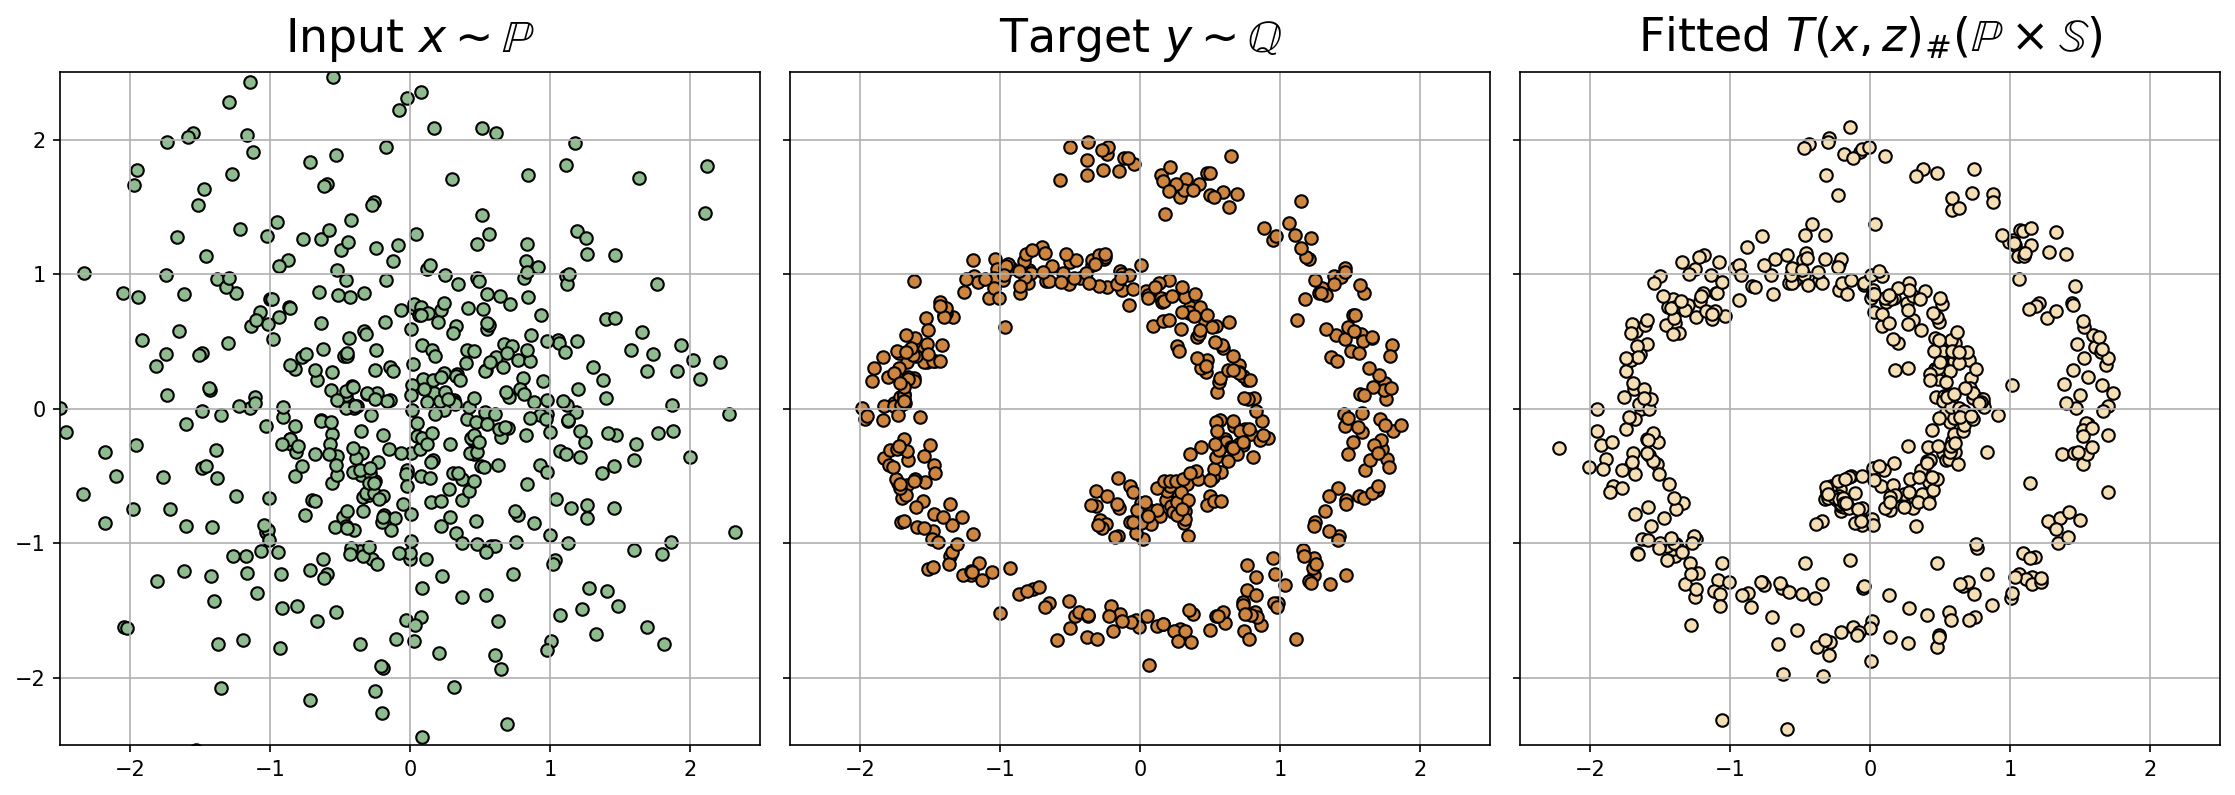

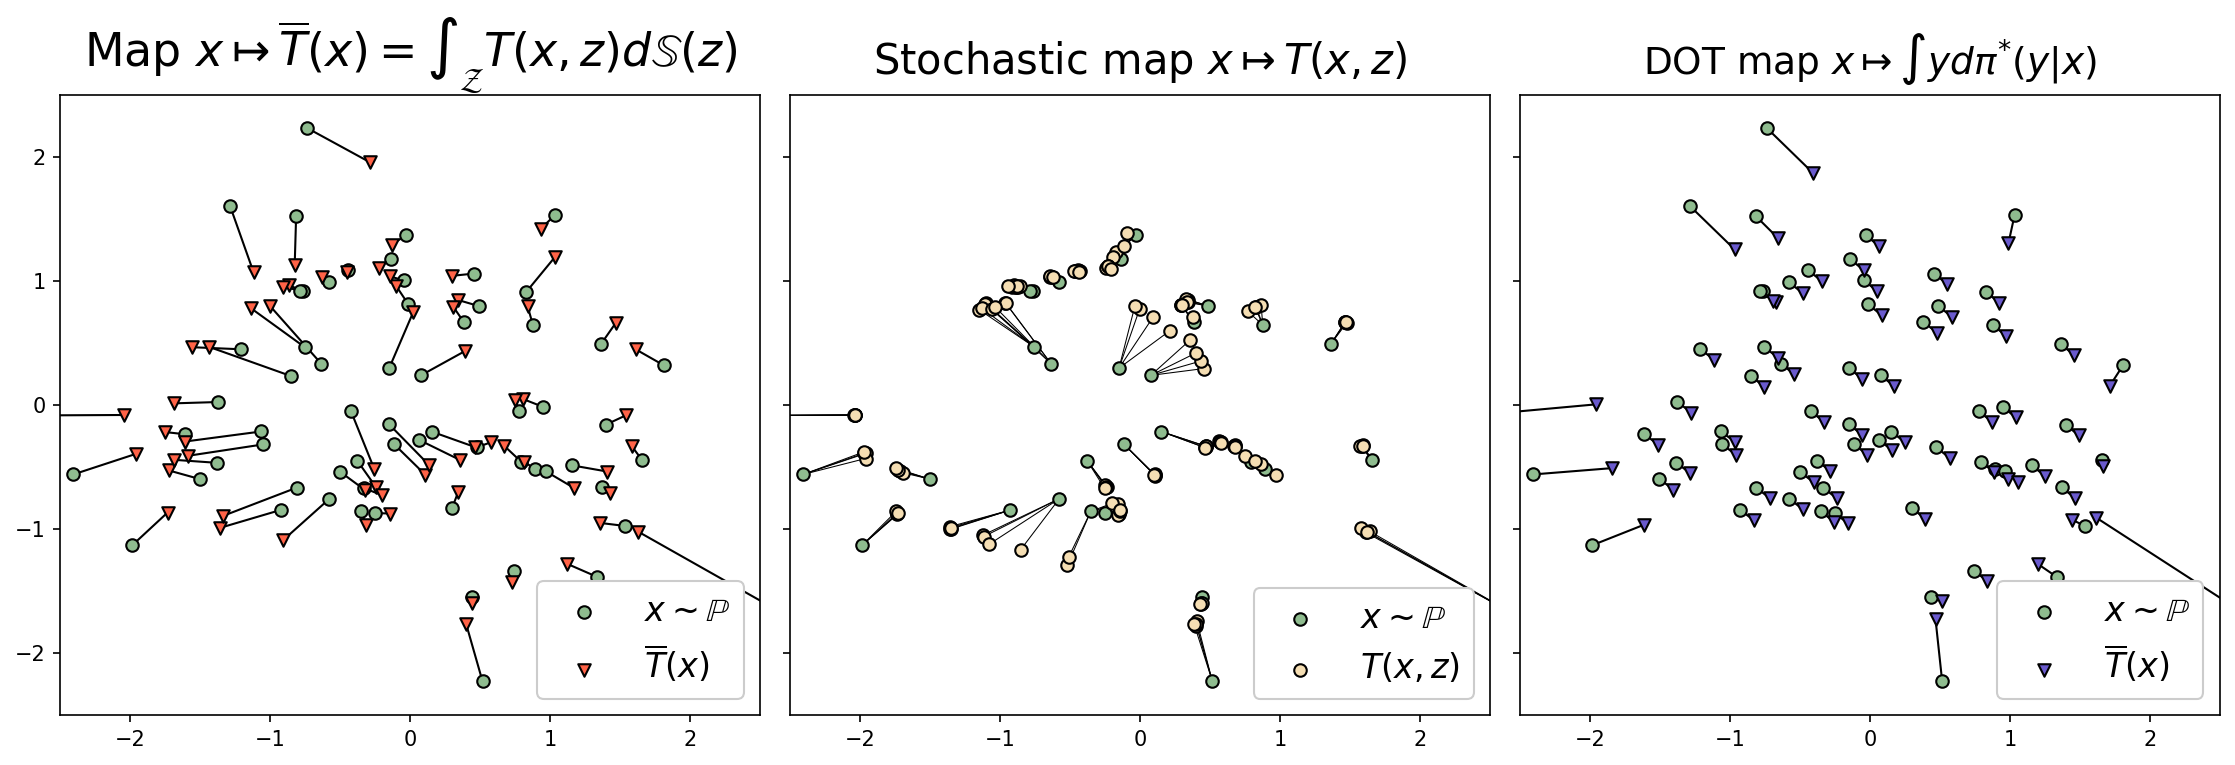

In [13]:
for step in tqdm(range(MAX_STEPS)):
    # T optimization
    unfreeze(T); freeze(D)
    for t_iter in range(T_ITERS):
        T_opt.zero_grad()
        
        X = X_loader.sample(BATCH_SIZE).to(DEVICE)
        # print(X.device)
        X = X.reshape(-1, 1, DIM).repeat(1, Z_SIZE, 1)

        with torch.no_grad():
            Z = torch.randn(BATCH_SIZE, Z_SIZE, ZD, device='cuda') * Z_STD
            XZ = torch.cat([X, Z], dim=2)
        
        T_XZ = T(
            XZ.flatten(start_dim=0, end_dim=1)).reshape(BATCH_SIZE, -1, DIM)
        # ).permute(1, 0).reshape(DIM, -1, Z_SIZE).permute(1, 2, 0)

        T_loss = F.mse_loss(X, T_XZ) - D(
            T_XZ.flatten(start_dim=0, end_dim=1)).mean() - T_XZ.var(dim=1).mean() / Z_SIZE
        T_loss.backward(); T_opt.step()
    
    del T_loss, T_XZ, X, Z
    gc.collect(); torch.cuda.empty_cache()

    # D optimization
    freeze(T); unfreeze(D)

    X = X_loader.sample(BATCH_SIZE).to(DEVICE)
    with torch.no_grad():
        Z = torch.randn(BATCH_SIZE, ZD, device='cuda') * Z_STD
        XZ = torch.cat([X, Z], dim=1)
        T_XZ = T(XZ)
    Y = Y_loader.sample(BATCH_SIZE).to(DEVICE)

    D_opt.zero_grad()
    D_loss = D(T_XZ).mean() - D(Y).mean()
    D_loss.backward(); D_opt.step()

    del D_loss, Y, X, T_XZ, Z, XZ
    gc.collect(); torch.cuda.empty_cache()

    if step % PLOT_INTERVAL == 0:
        clear_output(wait=True)
        print("Step", step)
        print("Plotting")
        print("(DOT map appears only on the last step)")

        fig, axes = plot_generated_2D(X_sampler, Y_sampler, T, ZD, Z_STD)
        plt.show()
        
        fig, axes = plot_bar_and_stochastic_2D(
            X_sampler, Y_sampler, T, ZD, Z_STD,
            plot_discrete=True if step == MAX_STEPS-1 else False
        )
        plt.show()

    gc.collect()
    torch.cuda.empty_cache()